In [1]:
import os

# Data Processing
import numpy as np
from numpy import genfromtxt
import sklearn
from sklearn.preprocessing import StandardScaler

# Base classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Stacking multiclassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

# Plotting
import matplotlib
import matplotlib.pyplot as plot
from matplotlib import cm

## Settings

In [2]:
# Training corpus paths
classical_training_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Feature Extraction\Classical\Classical Features.csv'
jazz_training_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Feature Extraction\Jazz\Jazz Features.csv'

# Generated Classical Songs
generated_songs_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Generation\Classical\Features'
export_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Generation\Classical\Classifications.csv'

# Generated Jazz Songs
# generated_songs_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Generation\Jazz\Features'
# export_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Generation\Jazz\Classifications.csv'

# 0 for classical, 1 for jazz
classification_class = 0

# Number of songs to train on from each genre 
num_training_songs = 8460

# File naming format for generated songs
file_format = 'epochs_40_samp_length_{}_seq_length_{}.csv'
# Song generation parameters
sample_lengths = [1000, 2000, 3000]
sequence_lengths = [10, 50, 100, 200, 300]

# Set the plot font
font = {'family' : 'DejaVu Sans',
        'size'   : 18}

matplotlib.rc('font', **font)

## Load the Training Feature Data

In [3]:
def load_training_samples(group1_path, group2_path, num_songs):
    # Load features for training
    group1_features = genfromtxt(group1_path, delimiter=',', max_rows=num_songs)
    group2_features = genfromtxt(group2_path, delimiter=',', max_rows=num_songs)
    
    # Combine the features from both groups into one training set
    training_samples = np.concatenate((group1_features, group2_features), axis=0)
    # Generate the classifications for the training set
    training_classifs = ([0] * num_songs) + ([1] * num_songs)
    
    return (training_samples, training_classifs)

## Load the Testing Feature Data

In [4]:
def load_testing_samples(features_path, file_format, sample_length, sequence_length):
    # Construct the path to the generated songs features file
    file_name = file_format.format(sample_length, sequence_length)
    file_path = os.path.join(generated_songs_path, file_name)
    
    # Load the features of the generated songs
    features = genfromtxt(file_path, delimiter=',')
    
    return features

## Load the Full Feature Set

In [5]:
# Load the features for 8450 samples from each genre
(training_samples, training_classifs) = load_training_samples(classical_training_path, jazz_training_path, 8450)

# Compute the mean and varience of the training set
scaler = StandardScaler().fit(training_samples)
# Normalize training set
training_samples = scaler.transform(training_samples)

## Create Estimators

In [6]:
lda_model = LinearDiscriminantAnalysis(solver='svd')
knn_model = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=13, p=1.0)
svm_model = svm.SVC(probability=False, kernel='rbf', C=1, degree=1, gamma=0.08, coef0=1.0)
rf_model  = RandomForestClassifier()

base_learners = [('est_1', lda_model), ('est_2', knn_model), ('est_3', svm_model), ('est_4', rf_model)]

final_estimator = LogisticRegression()

## Create and Train the Ensemble

In [7]:
print('Training... ', end = '')

model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)
model.fit(training_samples, training_classifs)

print('done')

Training... done


## Classify the Generated Songs from Each NN Model

In [8]:
print('\nClassifying... ', end = '')

num_points = len(sample_lengths) * len(sequence_lengths)

# The position along each axis for the data points
x_sample_lengths = []
y_sequence_lengths = []
z_scores = []
z_accuracies = []

# Iterate through the parameter combinations

sample_length = 1000
sequence_length = 10

for sample_length in sample_lengths:
    for sequence_length in sequence_lengths:
        # Load the features of the generated songs
        testing_samples = load_testing_samples(generated_songs_path, file_format, sample_length, sequence_length)

        # Normalize the features
        testing_samples = scaler.transform(testing_samples)
        
        # Determine the probability scores
        score_list = model.predict_proba(testing_samples)
        class_scores = score_list[:, classification_class]
        average_score = np.average(class_scores)
        
        # Determine the accuracy
        accuracy = model.score(testing_samples, [classification_class] * 20)

        # Store the data point
        x_sample_lengths.append(sample_length)
        y_sequence_lengths.append(sequence_length)
        z_scores.append(average_score)
        z_accuracies.append(accuracy)
        
print('done')


Classifying... done


## Plot the Average Scores

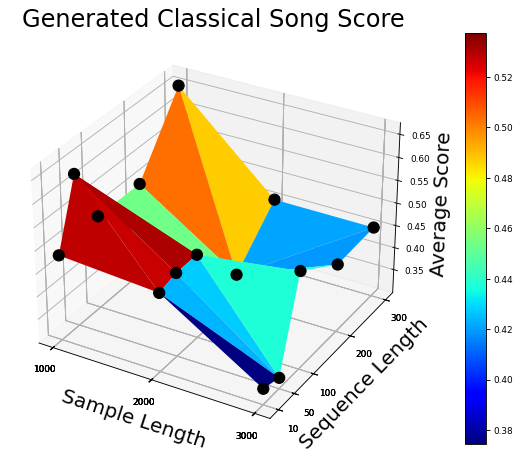

Best Score: 65.06267308741062
Worst Score: 32.11054149183403
[0.484515434761929, 0.6294195788699749, 0.5014992340621902, 0.5002410202488781, 0.6506267308741062, 0.46951448390643924, 0.48054335686058963, 0.4809478005132686, 0.35828273340935607, 0.4530830839858023, 0.3322808019687699, 0.32110541491834027, 0.5113446792393603, 0.44697537850192715, 0.45226758579371057]


In [11]:
# Set the plot settings
fig = plot.figure(figsize=(12, 6), dpi=80)
ax = fig.add_subplot(projection='3d')

if classification_class == 0:
    plot.title('Generated Classical Song Score')
else:
    plot.title('Generated Jazz Song Score')

plot.rc('xtick', labelsize=8)
plot.rc('ytick', labelsize=8)

# Set the axis labels
ax.set_xlabel('Sample Length')
ax.set_ylabel('Sequence Length')
ax.set_zlabel('Average Score')

plot.xticks(x_sample_lengths)
plot.yticks(y_sequence_lengths)

# Create a mesh from the points and display it
surf = ax.plot_trisurf(x_sample_lengths, y_sequence_lengths, z_scores, cmap=cm.jet)
# Plot the data points
ax.scatter3D(x_sample_lengths, y_sequence_lengths, z_scores, c='black', s=100, alpha=1.0)

fig.colorbar(surf)

fig.tight_layout()
plot.show()

print('Best Score: {}'.format(max(z_scores) * 100))
print('Worst Score: {}'.format(min(z_scores) * 100))
print(z_scores)

## Plot the Average Accuracy

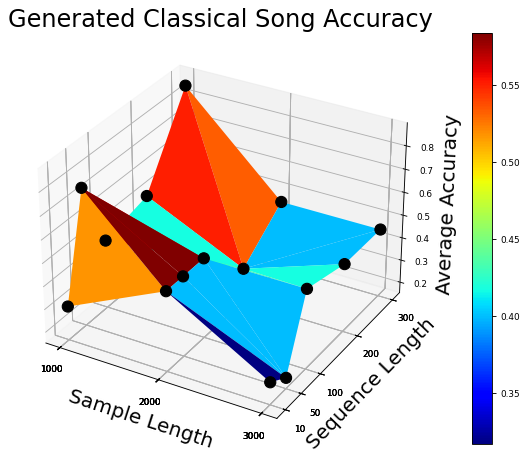

Best Accuracy: 85.0
Worst Accuracy: 20.0
[0.3, 0.75, 0.45, 0.5, 0.85, 0.5, 0.5, 0.5, 0.3, 0.45, 0.25, 0.2, 0.5, 0.45, 0.45]


In [13]:
# Set the plot settings
fig = plot.figure(figsize=(12, 6), dpi=80)
ax = fig.add_subplot(projection='3d')

if classification_class == 0:
    plot.title('Generated Classical Song Accuracy')
else:
    plot.title('Generated Jazz Song Accuracy')

plot.rc('xtick', labelsize=8)
plot.rc('ytick', labelsize=8)

# Set the axis labels
ax.set_xlabel('Sample Length')
ax.set_ylabel('Sequence Length')
ax.set_zlabel('Average Accuracy')

plot.xticks(x_sample_lengths)
plot.yticks(y_sequence_lengths)

# Create a mesh from the points and display it
surf = ax.plot_trisurf(x_sample_lengths, y_sequence_lengths, z_accuracies, cmap=cm.jet)
# Plot the data points
ax.scatter3D(x_sample_lengths, y_sequence_lengths, z_accuracies, c='black', s=100, alpha=1.0)

fig.colorbar(surf)

fig.tight_layout()
plot.show()

print('Best Accuracy: {}'.format(max(z_accuracies) * 100.0))
print('Worst Accuracy: {}'.format(min(z_accuracies) * 100.0))
print(z_accuracies)